In [8]:
pip install --upgrade tensorflow

Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Flatten
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [10]:

df = pd.read_csv(r'C:\Users\Pranav Desai\Desktop\Chronic Disease\Augmented kidney_dataset.csv')

In [11]:
x = df.drop("classification", axis=1).values
y = df["classification"].values

In [12]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)


In [13]:
x_scaled = x_scaled.reshape((x_scaled.shape[0], x_scaled.shape[1], 1))

In [14]:
x.shape[1]

24

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42, stratify=y)


In [16]:
# CNN Model
model = Sequential([
    Input(shape=(x_train.shape[1], 1)),

    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.4),

    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])


In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [18]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_heart_model.h5', save_best_only=True)


In [19]:
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2,callbacks=[early_stop, checkpoint], verbose=1)

Epoch 1/100
200/200 [==============================] - 7s 10ms/step - loss: 0.0943 - accuracy: 0.9650 - val_loss: 0.2314 - val_accuracy: 0.9281
Epoch 2/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0202 - accuracy: 0.9919 - val_loss: 0.0176 - val_accuracy: 0.9950
Epoch 3/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0110 - accuracy: 0.9962 - val_loss: 8.8903e-04 - val_accuracy: 1.0000
Epoch 4/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0049 - accuracy: 0.9986 - val_loss: 3.1345e-04 - val_accuracy: 1.0000
Epoch 5/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0066 - accuracy: 0.9980 - val_loss: 1.8310e-04 - val_accuracy: 1.0000
Epoch 6/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0017 - accuracy: 0.9998 - val_loss: 2.1638e-05 - val_accuracy: 1.0000
Epoch 7/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 7.0093

In [20]:
y_pred = model.predict(x_test)
y_pred_labels = (y_pred > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred_labels))
print(classification_report(y_test, y_pred_labels))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1250
           1       1.00      1.00      1.00       750

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [21]:
# Extract values from history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history.get('accuracy', history.history.get('acc'))  # Some versions use 'acc'
val_accuracy = history.history.get('val_accuracy', history.history.get('val_acc'))

epochs = range(1, len(loss) + 1)


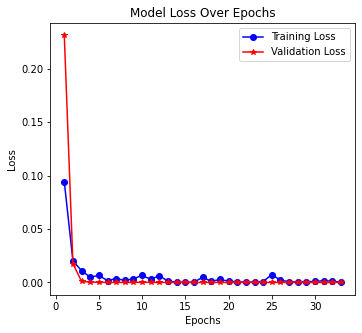

In [22]:
# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()

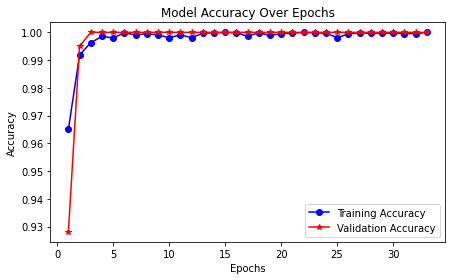

In [23]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
import tensorflow as tf
import os
import time
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
from tensorflow.python.profiler import model_analyzer
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder

def evaluate_model_metrics(model, x_test, y_test, model_name="model_metrics"):
    results = {}

    # Total Parameters
    results['total_parameters'] = model.count_params()

    # FLOPs Calculation
    func = tf.function(lambda x: model(x))
    concrete_func = func.get_concrete_function(
        tf.TensorSpec([1] + list(model.input_shape[1:]), model.inputs[0].dtype)
    )
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    flops = model_analyzer.profile(
        graph=frozen_func.graph,
        options=ProfileOptionBuilder.float_operation()
    ).total_float_ops
    results['FLOPs'] = flops
    results['GFLOPs'] = flops / 1e9

    # Model Size
    model_path = f"{model_name}.h5"
    model.save(model_path)
    size_bytes = os.path.getsize(model_path)
    results['model_size_bytes'] = size_bytes
    results['model_size_MB'] = size_bytes / (1024 * 1024)

    # Inference Time
    start = time.time()
    model.predict(x_test)
    end = time.time()
    results['inference_time_seconds'] = end - start

    # Accuracy
    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    results['accuracy'] = acc

    return results
evaluate_model_metrics(model, x_test, y_test, model_name="model_metrics")

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


{'total_parameters': 158337,
 'FLOPs': 1860673,
 'GFLOPs': 0.001860673,
 'model_size_bytes': 1976608,
 'model_size_MB': 1.885040283203125,
 'inference_time_seconds': 0.12915253639221191,
 'accuracy': 1.0}